# **Predict Stock Prices with LSTM in PyTorch**

In this guided project, you will create a **basic model** to predict a stock's value using daily Open, High, Low, and Close prices. The stock market can be extremely volatile, influenced by various factors. This tutorial focuses on the following stock data parameters:

| Parameter | Description                                                             |
|-----------|-------------------------------------------------------------------------|
| **Open**  | The stock's price at market opening.                                    |
| **High**  | The highest trading price during market hours.                          |
| **Low**   | The lowest trading price during market hours.                           |
| **Close** | The stock's price at market closing. Financial institutions often use this value as the stock's daily benchmark. |


Given the significance of the Close value as a daily benchmark, it will be the primary focus for predictions. To achieve this, we will build a model using Long Short-Term Memory (LSTM), a type of Recurrent Neural Network (RNN) adept at handling large sets of time series data.

---


# **Introduction**

### **Recurrent Neural Networks (RNNs)**

**Recurrent Neural Networks (RNNs)** are a powerful type of neural network commonly used for tasks involving sequential data. Unlike traditional neural networks, RNNs can remember previous inputs, which helps them recognize patterns over time. This ability to retain **sequential memory** makes RNNs particularly effective for tasks like predicting stock prices or analyzing text.

### **How RNNs Work**?

RNNs are built using three main types of layers:

- **Input Layer**: This layer receives the data for the network.
- **Hidden Layer**: This layer **processes the information** and has loops that allow it to **pass information** from previous time steps to the next. This means the model can remember **past data while processing current inputs**.
- **Output Layer**: This layer produces the final prediction based on the processed information.

The **hidden state** of an RNN represents the information the model has stored from previous steps. The amount of information it retains can vary, depending on how long it needs to remember past data.

---

When training an RNN, after making a prediction, we compare it to the actual result using a **loss function**. This function helps us understand how far off our prediction was. We then use a process called **backpropagation** to adjust the model. During backpropagation, we calculate the gradients (which show how much to change each weight) and update the weights of each node in the neural network accordingly.

### **Why Use RNNs?**

The ability to work with sequential data makes RNNs especially useful for **time series data**, such as stock prices or weather patterns. This makes them a great choice for tasks where the order of data points is important for making accurate predictions.

---

In [132]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


from torch import nn
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### **[Long Short-Term Memory (LSTM)](https://ieeexplore.ieee.org/abstract/document/6795963)**

Recurrent backpropagation can be quite time-consuming, particularly due to insufficient and decaying error backflow. To address this issue, a specialized type of Recurrent Neural Network (RNN) called **Long Short-Term Memory (LSTM)** is utilized. **LSTMs** are designed to track long-term dependencies by modifying the model using gradients instead of traditional backpropagation. This capability is especially advantageous when working with **time series data**. The more historical data available, the better the model can train, resulting in more accurate predictions.

### **Structure of an LSTM**

An LSTM network contains an internal state variable that is adjusted based on weights and biases through three primary operation gates:

1. **Forget Gate**: Determines what information to discard from the previous state.
2. **Input Gate**: Decides which new information should be added to the current state.
3. **Output Gate**: Generates the next hidden state based on the current input and the internal state.

The architecture of an LSTM relies on the **tanh** and **sigmoid** functions, which help regulate the values within the network:

- The **tan(h)** function ensures values remain between -1 and 1.
- The **sigmoid** function regulates whether data should be remembered or forgotten.

### **Mathematical Representation of Each Gate**

The equations for the gates are as follows:
- **Forget Gate**:
    $f_t = \sigma(w_f * [h_{t-1}, x_t] + b_f)$

- **Input Gate**:
    $i_t = \sigma(w_i * [h_{t-1}, x_t] + b_i)$

- **Output Gate**:
    $O_t = \sigma(w_o * [h_{t-1}, x_t] + b_o)$

Where:  
- $w_f$, $w_i$, $w_o$ = weight matrices for the gates
- $h_{t-1}$ = previous hidden state
- $x_t$ = current input
- $b_f$, $b_i$, $b_o$ = biases for each gate
- $\sigma$ = sigmoid function

### **Gate Functions Explained**

- The **Forget Gate** determines which data to keep and which to discard.
- The **Input Gate** analyzes what new information should be added at the current time step.
- The **Output Gate** finalizes the updated hidden state, which will be passed to the next time step.

These gates allow LSTMs to efficiently store and analyze sequential data, leading to the development of accurate predictive models.

[**Source:** S. Hochreiter and J. Schmidhuber, "Long Short-Term Memory," in Neural Computation, vol. 9, no. 8, pp. 1735-1780, 15 Nov. 1997, doi: 10.1162/neco.1997.9.8.1735.](https://ieeexplore.ieee.org/abstract/document/6795963)


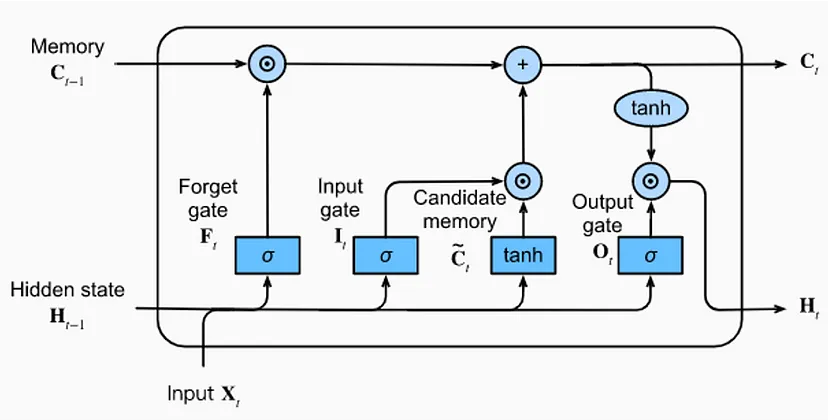

In [133]:
df = pd.read_csv("https://github.com/pri-cd/Data-Science-ML/raw/main/Personal-Projects/LSTM-STOCK/StockData.csv")
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.head()

,Date,Open,High,Low,Close
0,2018-03-27,173.68,175.15,166.92,168.340
1,2018-03-26,168.07,173.10,166.44,172.770
2,2018-03-23,168.39,169.92,164.94,164.940
3,2018-03-22,170.00,172.68,168.60,168.845
4,2018-03-21,175.04,175.09,171.26,171.270


In [134]:
stock_data = df
# Convert the date column into a Datetime object:
stock_data['Date'] = pd.to_datetime(df.Date)
print("Information about the dataset")
print(stock_data.info())

Information about the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9400 non-null   datetime64[ns]
 1   Open    9400 non-null   float64       
 2   High    9400 non-null   float64       
 3   Low     9400 non-null   float64       
 4   Close   9400 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 367.3 KB
None


- We can see that there are a total of 5 columns, the columns we want to input into the model are the last four columns: `index 1-4`.

- By printing the first and last 5 elements, we can see that the data is in inverse order.
- The most recent data stored at the beginning of the set and the oldest data is at the end.
- For our model, we need to input the data from oldest to most recent.
- The Pandas method `sort_values` can be used to sort the data in chronological order.


### **First 5 Elements in Dataset**

In [135]:
stock_data.head(5)

,Date,Open,High,Low,Close
0,2018-03-27,173.68,175.15,166.92,168.340
1,2018-03-26,168.07,173.10,166.44,172.770
2,2018-03-23,168.39,169.92,164.94,164.940
3,2018-03-22,170.00,172.68,168.60,168.845
4,2018-03-21,175.04,175.09,171.26,171.270


### **Last 5 Elements in Dataset**

In [136]:
stock_data.tail(5)

,Date,Open,High,Low,Close
9395,1980-12-18,26.63,26.75,26.63,26.63
9396,1980-12-17,25.87,26.00,25.87,25.87
9397,1980-12-16,25.37,25.37,25.25,25.25
9398,1980-12-15,27.38,27.38,27.25,27.25
9399,1980-12-12,28.75,28.87,28.75,28.75


In [137]:
stock_data = stock_data.sort_values(by="Date")
stock_data.head()

,Date,Open,High,Low,Close
9399,1980-12-12,28.75,28.87,28.75,28.75
9398,1980-12-15,27.38,27.38,27.25,27.25
9397,1980-12-16,25.37,25.37,25.25,25.25
9396,1980-12-17,25.87,26.00,25.87,25.87
9395,1980-12-18,26.63,26.75,26.63,26.63


## **Scaling The Data**

#### **Normalizing Data for Uniformity**

Once we've identified the specific data points we want to analyze (our "target variables"), the next step is to ensure they're all on the same scale. This is achieved through a process called normalization.

---
**Why Normalize?**
By normalizing, we transform the data so that all values fall within a specific range, typically between -1 and 1. This makes it easier for our model to process the data and identify patterns. Essentially, it ensures that no single data point has an unfairly large or small impact on the model's predictions.

---
**A Note on Data Exposure**

It's generally a good practice to keep the test data separate from the training data to avoid bias. However, in this specific case, we're using a simple normalization technique (min-max scaling) that only requires information about the highest and lowest values in the dataset. This information is unlikely to significantly impact the model's performance, so we can proceed with normalizing the test data as well.

In [138]:
price = stock_data[['High','Low','Open','Close']]
price[:5]

,High,Low,Open,Close
9399,28.87,28.75,28.75,28.75
9398,27.38,27.25,27.38,27.25
9397,25.37,25.25,25.37,25.25
9396,26.00,25.87,25.87,25.87
9395,26.75,26.63,26.63,26.63


In [139]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price = scaler.fit_transform(price.values)
print(price[:5])

[[-0.94884358 -0.94844388 -0.94899391 -0.94863261]
 [-0.95313783 -0.95280073 -0.95295751 -0.95297352]
 [-0.95893076 -0.95860987 -0.95877273 -0.95876139]
 [-0.95711507 -0.95680904 -0.95732616 -0.95696715]
 [-0.95495353 -0.95460157 -0.95512737 -0.95476776]]


## **Testing & Training Data**

Create input-output sequences for time series prediction.

Parameters:
- price_data (np.array): The array of stock price data.
- window_size (int): The number of time steps for the input sequence.
- test_set_size (int): The number of sequences to be reserved for testing.

Returns:
- train (list): Training data as a list of (input_sequence, output_label) tuples.
- test (list): Testing data as a list of (input_sequence, output_label) tuples.

In [140]:
def create_in_out_sequences(price_data, window_size, test_set_size=20):
    in_out_sequences = []
    price_length = len(price_data)

    # Generate sequences
    for i in range(price_length - window_size):
        input_sequence = price_data[i:i + window_size]
        output_label = price_data[i + window_size:i + window_size + 1][0][3]  # Assuming [0][3] for close price
        in_out_sequences.append((input_sequence, output_label))

    # Define train and test split
    train_set_size = len(in_out_sequences) - test_set_size
    train = in_out_sequences[:train_set_size]
    test = in_out_sequences[train_set_size:]

    return train, test

# Example usage:
train_window = 7
train, test = create_in_out_sequences(price_data=price, window_size=train_window)

- Normalised Data:

In [141]:
print(test[0], end='\n\n\n')
print(train[-1])

(array([[-0.52820808, -0.53303223, -0.53350981, -0.53283172],
       [-0.52982203, -0.53404883, -0.53440669, -0.5345102 ],
       [-0.53022552, -0.5352397 , -0.53215004, -0.53676747],
       [-0.53071547, -0.5332065 , -0.53512997, -0.53233975],
       [-0.52581598, -0.52789114, -0.5297198 , -0.52378816],
       [-0.51503711, -0.52013593, -0.52196618, -0.51390537],
       [-0.51189567, -0.51447202, -0.51401004, -0.51558385]]), -0.5163652148748373)


(array([[-0.53319403, -0.54107789, -0.54094519, -0.53121111],
       [-0.52820808, -0.53303223, -0.53350981, -0.53283172],
       [-0.52982203, -0.53404883, -0.53440669, -0.5345102 ],
       [-0.53022552, -0.5352397 , -0.53215004, -0.53676747],
       [-0.53071547, -0.5332065 , -0.53512997, -0.53233975],
       [-0.52581598, -0.52789114, -0.5297198 , -0.52378816],
       [-0.51503711, -0.52013593, -0.52196618, -0.51390537]]), -0.5155838518304154)


## **Model Architecture**

* **Hidden Layer Size:**
  - `self.hidden_layer_size`: Stores the size of the hidden layer, defaulting to 100.

* **LSTM Layer:**
  - `self.lstm`: Initializes an LSTM layer.
    - Takes input sequences of size `input_size`.
    - Outputs sequences of size `hidden_layer_size`.

* **Linear Layer:**
  - `self.linear`: Initializes a fully connected linear layer.
    - Maps the LSTM output to the desired `output_size`.

* **Forward Pass:**
  - The `forward` method takes an input sequence and produces a prediction.

In [142]:
class LSTM(nn.Module):
    # The __init__ function is the setup function that initializes our LSTM model
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()  # Calls the initialization of the parent class (nn.Module)

        # Set the size of the hidden layer, which stores information during processing
        self.hidden_layer_size = hidden_layer_size

        # Define the LSTM layer
        # The LSTM layer will take 'input_size' features as input and has 'hidden_layer_size' hidden units
        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        # Define a linear layer (also known as a "fully connected" layer)
        # This layer maps the LSTM output to the desired output size (output_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    # The forward function defines how the input data flows through the model
    def forward(self, input_seq):
        # Initialize the hidden state and cell state with zeros
        # These tensors represent the initial state of the LSTM's "memory"
        hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                       torch.zeros(1, 1, self.hidden_layer_size))

        # Pass the input sequence through the LSTM layer
        # `view` reshapes the input so it's compatible with LSTM input requirements
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)

        # Apply the linear layer to the LSTM output
        # Reshape `lstm_out` so that the linear layer can process it
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        # Return the last prediction in the sequence as the final output
        return predictions[-1]

In [143]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## **Training The Data**

Now that all the necessary parameters have been defined, we can use the `LSTM()` and `create_in_out_sequence()` to train the model. We are training this model to 5 epochs.


In [144]:
from tqdm.notebook import tqdm

# Set the number of epochs (complete passes through the dataset)
epochs = 5

# Loop through the number of epochs
for i in tqdm(range(epochs)):
    epoch_loss = 0  # Initialize total loss for the epoch

    # Loop through the training data
    for seq, labels in tqdm(train):
        # Convert the sequence and labels from NumPy arrays to PyTorch tensors
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        # Reset the gradients of the optimizer
        optimizer.zero_grad()

        # Forward pass: get predictions from the model
        y_pred = model(seq)

        # Reshape labels to match the output shape of the model
        labels = labels.view(1)

        # Calculate the loss between predictions and actual labels
        single_loss = loss_function(y_pred, labels)

        # Backward pass: compute gradients for the optimizer
        single_loss.backward()

        # Update the model parameters based on computed gradients
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_loss += single_loss.item()

    # Calculate the average loss for this epoch
    average_loss = epoch_loss / len(train)

    # Print the average loss for this epoch
    print(f'epoch: {i:3} loss: {average_loss:.10f}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9373 [00:00<?, ?it/s]

epoch:   0 loss: 0.0019771121


  0%|          | 0/9373 [00:00<?, ?it/s]

epoch:   1 loss: 0.0008988863


  0%|          | 0/9373 [00:00<?, ?it/s]

epoch:   2 loss: 0.0008647453


  0%|          | 0/9373 [00:00<?, ?it/s]

epoch:   3 loss: 0.0008987761


  0%|          | 0/9373 [00:00<?, ?it/s]

epoch:   4 loss: 0.0008520683


In [145]:
# Set the model to evaluation mode
model.eval()
actual = []
pred = []

# Loop through the test data
for seq, labels in test:
    # Convert the sequence and labels from NumPy arrays to PyTorch tensors
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

    # Append actual labels to the list
    actual.append(labels.item())

    # Perform inference without tracking gradients
    with torch.no_grad():
        # Forward pass: get predictions from the model
        prediction = model(seq)

        # Assuming the model returns a tensor, convert it to a scalar
        pred.append(prediction.item())

# Convert lists to NumPy arrays for further analysis
actual = np.array(actual)
pred = np.array(pred)

# Optionally, print the results or calculate metrics
print("Actual values:", actual, end='\n\n')
print("Predicted values:", pred)

# Example: Calculate Mean Absolute Error (MAE) as a performance metric
mae = np.mean(np.abs(actual - pred))
print(f'Mean Absolute Error: {mae:.4f}')


Actual values: [-0.51636523 -0.52539432 -0.52189261 -0.52012736 -0.5205614  -0.52530748
 -0.51978004 -0.51098251 -0.50594705 -0.51101142 -0.51543915 -0.51483142
 -0.51665461 -0.52452612 -0.52469975 -0.53618866 -0.54320645 -0.55450732
 -0.53184777 -0.5446679 ]

Predicted values: [-0.53855819 -0.53866643 -0.54260731 -0.54418665 -0.54151469 -0.54071176
 -0.54411441 -0.5413276  -0.53816468 -0.53540522 -0.53601831 -0.53882366
 -0.53854376 -0.53956157 -0.54303557 -0.54254287 -0.54666048 -0.5500043
 -0.55376118 -0.54791796]
Mean Absolute Error: 0.0184


In [146]:
pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [147]:
pred_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(pred)])
print(pred_new[:,3])

[170.45121914 170.4138161  169.05204492 168.5063025  169.42959725
 169.70705115 168.53126532 169.4942493  170.58719647 171.54072671
 171.3288723  170.35948284 170.45620346 170.10449959 168.90405989
 169.07430961 167.65147014 166.49601294 165.19782279 167.21694821]


In [148]:
actual_new = scaler.inverse_transform(np.c_[np.zeros(20),np.zeros(20),np.zeros(20),np.array(actual)])
print(actual_new[:,3])

[178.11999474 174.99999256 176.21000958 176.81999212 176.67000924
 175.03000149 176.94000725 179.97999249 181.71999569 179.97000324
 178.44000078 178.65000152 178.0199993  175.2999995  175.24000223
 171.27000783 168.84501005 164.93999725 172.77000135 168.34000729]


In [149]:
mae = mean_absolute_error(actual_new, pred_new)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1.5860488278418792
Root Mean Squared Error (RMSE): 3.477641564554088


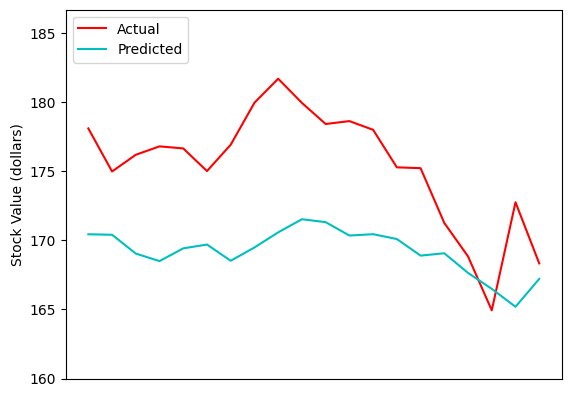

In [150]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label='Actual')
ax.plot(pred_new[:,3], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')
plt.show()

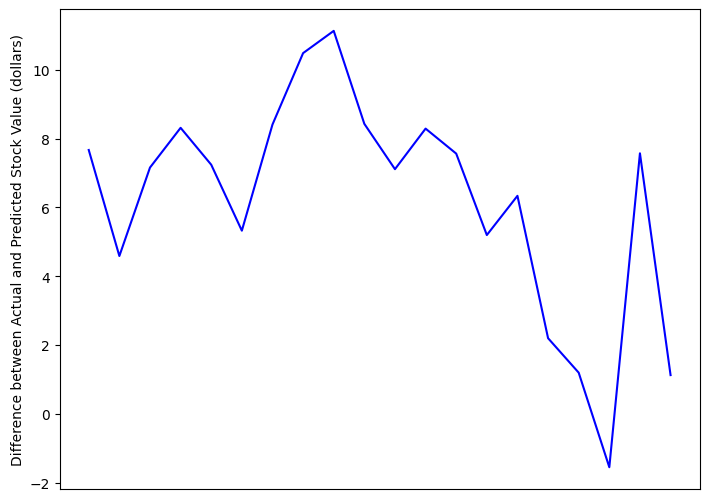

In [151]:
difference = actual_new - pred_new
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference between Actual and Predicted Stock Value (dollars)')
plt.xticks([])
plt.show()